<a id='cell100'></a>

### Table of contents


[1. Motivation](#cell1)

[1. Load and preprocess the files](#cell7)

[2. Exploratory data analysis](#cell2)

[3. Kaplan-Meier survival curve for the whole patient cohort](#cell3)

[4. Feature Selection](#cell4)

[5. Proportional Hazard Regression](#cell5)

[6. Final COX model](#cell6)

[7. Conclusion](#cell8)


<a id='cell1'></a>

### Motivation: 

Cancer is a big burden for our society. According to the projections from cancer.gov, there will be 50% more cases in the world in 2030. In the US, we are projected to spend 200 billion dollars on cancer care in the same year. One of the promising ways to solve this problem is called precision medicine. The idea is that we can further individualize treatments according to their genotype, gene expression and biomarkers.In this project I focused on prognosis part of the precision medicine.

### Project

This is an important issue because many medical decisions benefit from an accurate prognosis. For example, female breast cancer patients may need to delay their treatment for fertility preservation. They want to know the associate risk with that. As an another example, what is the benefit of having additional treatment X ? For risky treatments such as chemotherapy doctors need to know how much increase in survival their patients will get in order to balance the risks and the benefits of the treatment.

To individualize prognosis for each patient, I used their gene expression profile and clinical information. After feature selection, I used a specific type of regression (COX) to build a predictive model. Finally using this model I produced survival predictions, and calculated the benefit of the adjuvant chemotherapy to make treatment recommendations.

I obtained the data by combining multiple files that I gathered through Genomic Data Commons API. I have 1075 patients, and I have the gene expression levels for 17000 genes. Whether chemotherapy is given to the patients, and their cancer stage are clinical features, the number of days they lived after the diagnosis and vitality are labels.

For feature selection I divided patients into two groups along a cut-off value that maximizes the log-rank statistic. Then, I ranked p-values and corrected for multiple hypothesis testing. What I am doing essentially is trying to find genes that have the maximum survival difference between high and low groups. This procedure identified prognostic genes and reduced the number of features to about 300.

Next to build my model, I used COX proportional hazards regression. This technique is used in clinical research to relate risk factors or exposures to survival time. After checking the model assumptions, a stepwise procedure is used for further feature selection. 

### Result

And to validate my model I used concordance index (c-index) which is the fraction of pairs where the observation with the higher survival time have the higher probability of survival predicted by your model. So the model only using clinical information or genes had an accuracy of 0.60, but combining both genes and clinical features in my model I was able to get c-index of 0.65 (in the validation data). Therefore by using information from patient’s gene expression profile I was able to increase the accuracy of my survival predictions.

References:

1. http://science.sciencemag.org/content/357/6352/eaan2507

2. http://www.cancer.gov

[Top](#cell100)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib
import pandas as pd
import seaborn as sns
import timeit
from scipy.stats import sem,percentileofscore
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import k_fold_cross_validation,concordance_index
from lifelines.statistics import logrank_test
np.random.seed(40)
from src.utils import *

<a id='cell7'></a>
### Load and preprocess the files
[Top](#cell100)

These are the list of all genes we will be working with. The genes have been selected to satisfy several criteria. See references above.

In [2]:
gene_list_file = open('data/all_genes_list.txt', 'r')
all_genes_list = gene_list_file.read().splitlines()
gene_list_file.close()
all_genes_list[:5]

['RAB4B', 'TIGAR', 'RNF44', 'DNAH3', 'RPL23A']

Drop the duplicates:

In [3]:
patient_df = pd.read_csv('data/patient_df.txt')
print(patient_df.shape)
patient_df.drop_duplicates(subset=['Patient_ID'],inplace=True)
print(patient_df.shape)
patient_df.head()

(1205, 17051)
(1075, 17051)


,Patient_ID,RAB4B,TIGAR,RNF44,DNAH3,RPL23A,ARL8B,CALB2,MFSD3,PIGV,...,Days,Sex,Stage,Vitality,Stage_number,Stage_name,Sex_name,Vitality_name,Age,3_years
0,TCGA-EW-A2FV,3.861754,4.364349,6.590762,0.016019,109.782413,36.287527,0.664490,13.554242,5.711862,...,788,0,5,0,3,iiic,Female,Alive,39.0,-1
1,TCGA-AN-A0XP,3.884672,3.227236,10.947821,0.001076,126.334180,48.724383,0.264691,11.718728,8.425504,...,9,0,2,0,3,iiia,Female,Alive,69.0,-1
2,TCGA-BH-A0DZ,2.278625,3.587834,7.450671,0.007373,724.387336,47.510202,6.865322,5.041987,4.152773,...,495,0,0,0,2,iib,Female,Alive,43.0,-1
4,TCGA-C8-A275,5.634410,4.553211,8.998139,0.012666,381.585980,39.334927,3.751131,13.794119,3.649692,...,1,0,4,0,2,iia,Female,Alive,56.0,-1
5,TCGA-AC-A3YI,2.867077,4.652717,10.057819,0.013368,156.058250,29.999282,2.674732,9.397424,3.593808,...,707,0,5,0,3,iiic,Female,Alive,74.0,-1


Add additional clinical info:

In [4]:
clinical_info = pd.read_csv('data/clinical_info.csv')
clinical_info.rename(index=str,columns={'bcr_patient_barcode':'Patient_ID'},inplace=True)
print(clinical_info.shape)
clinical_info.drop_duplicates(subset=['Patient_ID'],inplace=True)
print(clinical_info.shape)
patient_df = patient_df.merge(right=clinical_info,on='Patient_ID',how='left')
clinical_info.head()

(1097, 5)
(1097, 5)


,Patient_ID,Chemotherapy,ER_status,PR_status,HR_status
0,TCGA-D8-A1XV,0,Positive,Positive,1.0
1,TCGA-BH-A0DD,1,Positive,Positive,1.0
2,TCGA-AO-A12E,1,Positive,Positive,1.0
3,TCGA-AC-A23E,0,Positive,Positive,1.0
4,TCGA-D8-A1XT,1,Negative,Negative,0.0


Drop the samples without HR_status variable, which shows hormone receptor status. Then disply the dataframe.

In [5]:
patient_df = patient_df[~pd.isnull(patient_df['HR_status'])]
print(patient_df.shape)
patient_df.head()

example_df = patient_df.loc[21:26,['Patient_ID']+all_genes_list[:6]+['Chemotherapy','Stage_name','Days','Vitality_name']]
example_df.rename(columns={'Stage_name':'Cancer_Stage',
                           'Vitality_name':'Vitality',
                          'Chemotherapy':'Chemo'},inplace=True)
pd.options.display.max_columns = 8
example_df.set_index('Patient_ID',inplace=True)
example_df.tail()

(1026, 17055)


,RAB4B,TIGAR,RNF44,DNAH3,...,Chemo,Cancer_Stage,Days,Vitality
Patient_ID,,,,,,,,,
TCGA-A8-A08G,3.004502,3.868944,11.266571,0.044421,...,1,iia,607,Alive
TCGA-AR-A24R,1.821419,4.037560,10.003361,0.035473,...,1,iiia,3430,Alive
TCGA-AR-A1AM,4.430708,2.375668,12.840301,0.080209,...,1,iiia,2991,Alive
TCGA-BH-A1F6,1.618035,5.659580,5.540643,0.029454,...,0,na,2965,Dead
TCGA-A2-A0CP,3.913465,2.307595,8.675910,0.020194,...,1,ia,2813,Alive


### Exploratory data analysis <a id='cell2'></a>

[Top](#cell100)

Distribution of survival times:

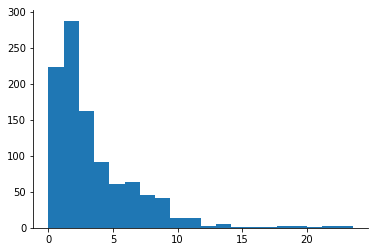

In [6]:
import matplotlib.pyplot as plt
patient_df['Days'] = patient_df['Days'].astype(int)
ax = (patient_df['Days']/365).hist(bins=20)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

We have small number of male patients

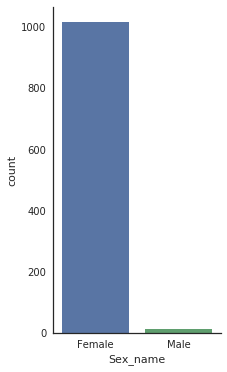

In [7]:
plt.figure(figsize=(3,6))
sns.set(style='white')
ax = sns.countplot(x='Sex_name', data=patient_df)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

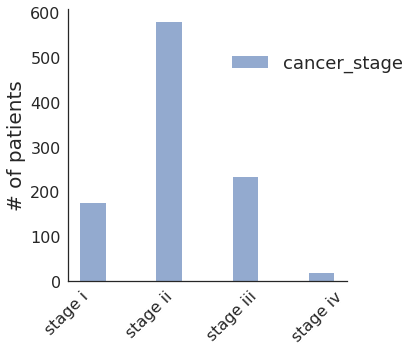

In [8]:
plt.figure(figsize=(5,5))
plt.hist(patient_df[(patient_df['Stage_number']!=-1)]["Stage_number"].reset_index(drop=True), alpha=0.6, label="cancer_stage",normed=False)

ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
ax.set_xticklabels(['','stage i','stage ii','stage iii','stage iv'],rotation=45, rotation_mode="anchor", ha="right")
plt.tick_params(axis='both', which='major', labelsize=16)
axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.ylabel('# of patients', **axis_font)
font_prop = FontProperties()
font_prop.set_size(18)
plt.legend(prop=font_prop,frameon=False,bbox_to_anchor=(1.1, 0.8),
           bbox_transform=plt.gcf().transFigure)
plt.show()

If we were interested in building a logistic regression model based on a single time point(such as 3 year survival), we would need to ignore censored patients who were alive less than 3, or non-censored patients who died after 3 years. Histogram below takes this approach, even though it is flawed because it would introduce bias in the model.

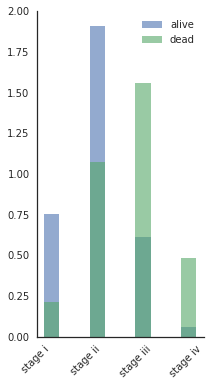

In [9]:
plt.figure(figsize=(3,6))
plt.hist(patient_df[(patient_df['3_years']==0)&(patient_df['Stage_number']!=-1)]["Stage_number"].reset_index(drop=True), alpha=0.6, label="alive",normed=True)
plt.hist(patient_df[(patient_df['3_years']==1)&(patient_df['Stage_number']!=-1)]["Stage_number"].reset_index(drop=True), alpha=0.6, label="dead",normed=True)
plt.legend()
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
ax.set_xticklabels(['','stage i','stage ii','stage iii','stage iv'],rotation=45, rotation_mode="anchor", ha="right")
plt.show()

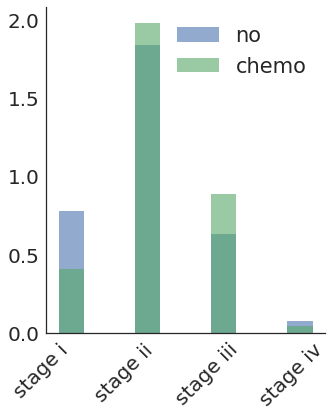

In [10]:
plt.figure(figsize=(5,6))
plt.hist(patient_df[(patient_df['Chemotherapy']==0)&(patient_df['Stage_number']!=-1)]["Stage_number"].reset_index(drop=True), alpha=0.6, label="no",normed=True)
plt.hist(patient_df[(patient_df['Chemotherapy']==1)&(patient_df['Stage_number']!=-1)]["Stage_number"].reset_index(drop=True), alpha=0.6, label="chemo",normed=True)
plt.legend(fontsize=21)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.set_xticklabels(['','stage i','stage ii','stage iii','stage iv'],rotation=45, rotation_mode="anchor", ha="right",**axis_font)
plt.tick_params(axis='both', which='major', labelsize=20)

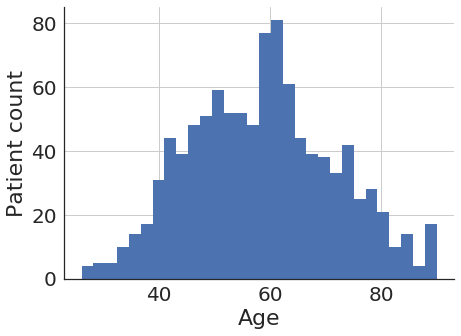

In [11]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
patient_df['Age'].hist(bins=30,ax=ax)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
plt.xlabel("Age",**axis_font)
plt.ylabel("Patient count",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)

Following two figures are concerned with the question of bias in the chemotherapy variable. In other words is there a systematic difference between people who got the chemotherapy vs people who did not.

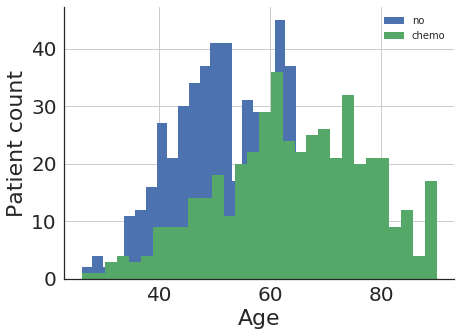

In [12]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
patient_df.loc[patient_df.Chemotherapy==1,'Age'].hist(bins=30,ax=ax,label='no')
patient_df.loc[patient_df.Chemotherapy==0,'Age'].hist(bins=30,ax=ax,label='chemo')
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
plt.xlabel("Age",**axis_font)
plt.ylabel("Patient count",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

<a id='cell3'></a>
### Kaplan-Meier survival curve for all patients
[Top](#cell100)

Constructing a kaplan-meier survival curve is one of the key methods in survival analysis.

median: 10.797260274
3_year: KM_estimate    0.906699
Name: 2.99452054795, dtype: float64
5_year: KM_estimate    0.830784
Name: 4.98630136986, dtype: float64


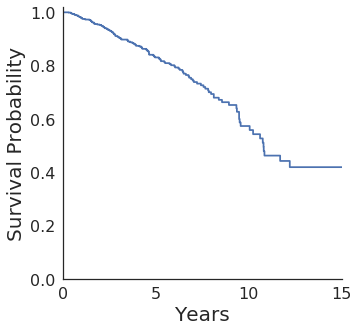

In [13]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
kmf = KaplanMeierFitter()
kmf.fit(patient_df['Days']/365, 
                       patient_df['Vitality'])

kmf.plot(ci_show=False,ax=ax)

print('median:',kmf.median_)
survival_function = kmf.survival_function_
#print(survival_function[:10])
print('3_year:',survival_function.loc[min(survival_function.index, key=lambda x:abs(x-3))])
print('5_year:',survival_function.loc[min(survival_function.index, key=lambda x:abs(x-5))])

axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel('Years', **axis_font)
plt.ylabel('Survival Probability', **axis_font)
font_prop = FontProperties()
font_prop.set_size(18)
plt.legend(prop=font_prop,frameon=False,labels='')
ax.legend_.remove()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.ylim((0,1.02))
plt.xlim((0,15))
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.show()

### KM curve for one of the genes ( comparing patient who express this gene high vs low levels)


15.4437417055


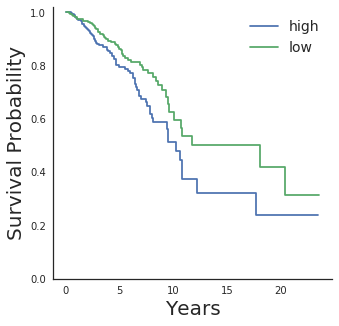

In [14]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
gene = 'LRP11'
LRP11_median = np.median(patient_df[gene])
print(LRP11_median)

kmf = KaplanMeierFitter()
kmf.fit(patient_df.loc[patient_df[gene]>LRP11_median,'Days']/365, 
                       patient_df.loc[patient_df[gene]>LRP11_median,'Vitality'], label='high')
kmf.plot(ci_show=False,ax=ax)

kmf.fit(patient_df.loc[patient_df[gene]<=LRP11_median,'Days']/365, 
                       patient_df.loc[patient_df[gene]<=LRP11_median,'Vitality'], label='low')
kmf.plot(ax=ax,ci_show=False)

axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel('Years', **axis_font)
plt.ylabel('Survival Probability', **axis_font)
font_prop = FontProperties()
font_prop.set_size(14)
plt.legend(prop=font_prop,frameon=False)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.ylim((0,1.02))
#plt.xlim((0,15))
plt.show()

In [15]:
results = logrank_test(patient_df.loc[patient_df['LRP11']<LRP11_median,'Days']/365, 
                       patient_df.loc[patient_df['LRP11']>=LRP11_median,'Days']/365, 
                       patient_df.loc[patient_df['LRP11']<LRP11_median,'Vitality'], 
                       patient_df.loc[patient_df['LRP11']>=LRP11_median,'Vitality'], alpha=.99)

print(results.p_value, results.test_statistic)

0.011086870859 6.45133973432


This is the p_value for the log-rank test based on median seperation.

### Train-Validation Split

In [16]:
valid_df = patient_df.sample(frac=0.3,random_state=40)
patient_df.drop(valid_df.index,inplace=True)
print(patient_df.shape)
print(valid_df.shape)

(718, 17055)
(308, 17055)


<a id='cell4'></a>

### Calculate the best cut (threshold) point for maximum log-rank

[Top](#cell100)

##### Warning: The next cell takes an hour to execute if trainining cutoffs have not been provided

In [ ]:
start_time = timeit.default_timer()

def calculate_cutoffs(patient_df,all_genes_list,quantiles):
    training_cutoffs = []

    for gene in all_genes_list:
        best_value = 0
        best_p = 1

        for quantile in quantiles:
            current_value = patient_df[gene].quantile(quantile)
            results = logrank_test(patient_df.loc[patient_df[gene]>current_value,'Days']/365, 
                                   patient_df.loc[patient_df[gene]<=current_value,'Days']/365, 
                                   patient_df.loc[patient_df[gene]>current_value,'Vitality'], 
                                   patient_df.loc[patient_df[gene]<=current_value,'Vitality'], alpha=.99)
            if results.p_value<best_p:
                best_value = current_value
                best_p = results.p_value
                best_quantile = quantile

        kmf = KaplanMeierFitter()
        kmf.fit(patient_df.loc[patient_df[gene]>best_value,'Days']/365, 
                      patient_df.loc[patient_df[gene]>best_value,'Vitality'])
        higher_median = kmf.median_
        kmf.fit(patient_df.loc[patient_df[gene]<=best_value,'Days']/365, 
                      patient_df.loc[patient_df[gene]<=best_value,'Vitality'])
        lower_median = kmf.median_

        training_cutoffs.append((gene,best_value,best_p,best_quantile,higher_median,lower_median))


    training_cutoffs = pd.DataFrame(training_cutoffs,columns=['Symbols',
                                                             'Expression Cutoffs',
                                                             'log-rank P Values',
                                                             'best_quantile','higher_median','lower_median'])
    return training_cutoffs

print(timeit.default_timer()-start_time)
training_cutoffs = calculate_cutoffs(patient_df,all_genes_list,[i/10 for i in range(1,10)])
training_cutoffs.to_csv('training_cutoffs.csv')
training_cutoffs.head()

In [17]:
training_cutoffs= pd.read_csv('data/training_cutoffs_final.csv')
print(training_cutoffs[training_cutoffs.Symbols=='SPRY4'])
training_cutoffs.sort_values('log-rank P Values',inplace=True)
training_cutoffs.reset_index(drop=True,inplace=True)
training_cutoffs['corrected_p'] = training_cutoffs['log-rank P Values']*17000/(training_cutoffs.index+1)
training_cutoffs.head()

       Unnamed: 0 Symbols  Expression Cutoffs  log-rank P Values  \
12698       12698   SPRY4           10.900273           0.000083   

       best_quantile  
12698            0.9  


,Unnamed: 0,Symbols,Expression Cutoffs,log-rank P Values,best_quantile,corrected_p
0,11205,SYT14,0.000000,3.669134e-07,0.1,0.006238
1,1199,SSX2IP,2.403109,1.242261e-06,0.2,0.010559
2,9689,PAK1,6.135200,1.419052e-06,0.1,0.008041
3,9595,EIF3M,12.005094,1.606056e-06,0.1,0.006826
4,12854,LIMCH1,15.628451,2.795180e-06,0.9,0.009504


(643, 17055)
(75, 17055)
6.80273972603


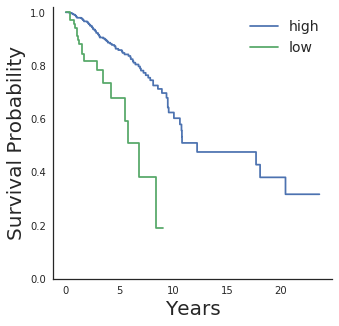

In [18]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
gene = 'SYT14'

LRP11_median = 0

high_group = patient_df[patient_df[gene]>LRP11_median]
low_group = patient_df[patient_df[gene]<=LRP11_median]
print(high_group.shape)
print(low_group.shape)

kmf = KaplanMeierFitter()
kmf.fit(high_group['Days']/365, 
                       high_group['Vitality'], label='high')
kmf.plot(ci_show=False,ax=ax)

kmf.fit(low_group['Days']/365, 
                       low_group['Vitality'], label='low')
print(kmf.median_)
kmf.plot(ax=ax,ci_show=False)

axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel('Years', **axis_font)
plt.ylabel('Survival Probability', **axis_font)
font_prop = FontProperties()
font_prop.set_size(14)
plt.legend(prop=font_prop,frameon=False)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.ylim((0,1.02))
#plt.xlim((0,15))
plt.show()

In [19]:
# source for cutoffs, could either be values from http://science.sciencemag.org/content/357/6352/eaan2507 or from
# training_cutoff table as calculate from above.
# breast_genes = pd.read_csv('Breast_cancer_genes_by_.csv')

breast_genes = training_cutoffs
breast_genes.head()
alpha_value = 0.05
print('Genes passing significance level:')

bonferroni_p = alpha_value/17000
selected_genes = breast_genes[breast_genes['log-rank P Values']<bonferroni_p]
selected_genes = breast_genes[breast_genes['corrected_p']<alpha_value][:50]
print(selected_genes.shape)
print(selected_genes[:5])
gene_list = selected_genes['Symbols'].tolist()
cutoff_level = selected_genes['Expression Cutoffs'].tolist()
print(gene_list[:5],cutoff_level[:5])

Genes passing significance level:
(50, 6)
   Unnamed: 0 Symbols  Expression Cutoffs  log-rank P Values  best_quantile  \
0       11205   SYT14            0.000000       3.669134e-07            0.1   
1        1199  SSX2IP            2.403109       1.242261e-06            0.2   
2        9689    PAK1            6.135200       1.419052e-06            0.1   
3        9595   EIF3M           12.005094       1.606056e-06            0.1   
4       12854  LIMCH1           15.628451       2.795180e-06            0.9   

   corrected_p  
0     0.006238  
1     0.010559  
2     0.008041  
3     0.006826  
4     0.009504  
['SYT14', 'SSX2IP', 'PAK1', 'EIF3M', 'LIMCH1'] [0.0, 2.403109425162, 6.135199881266002, 12.005094159889998, 15.628450837010007]


<a id='cell5'></a>

### Proportional Hazard Regression

[Top](#cell100)

### Test the assumptions of cox proportional hazards assumptions by plotting a log-log plot 

In [20]:
patient_df_binary = patient_df.copy()
valid_df_binary = valid_df.copy()

SYT14
(75, 17055)
(643, 17055)


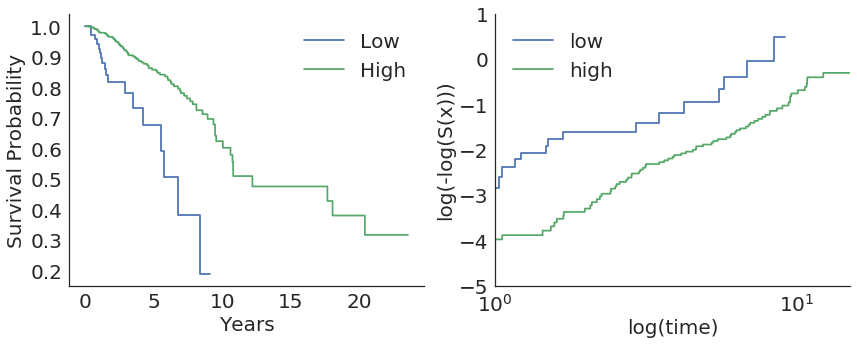

SSX2IP
(144, 17055)
(574, 17055)


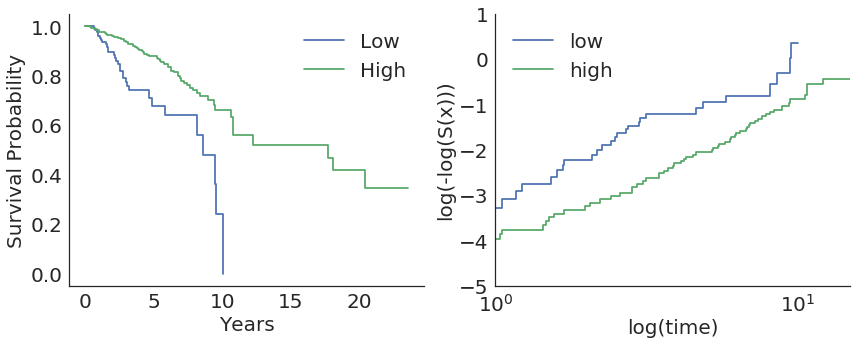

PAK1
(72, 17055)
(646, 17055)


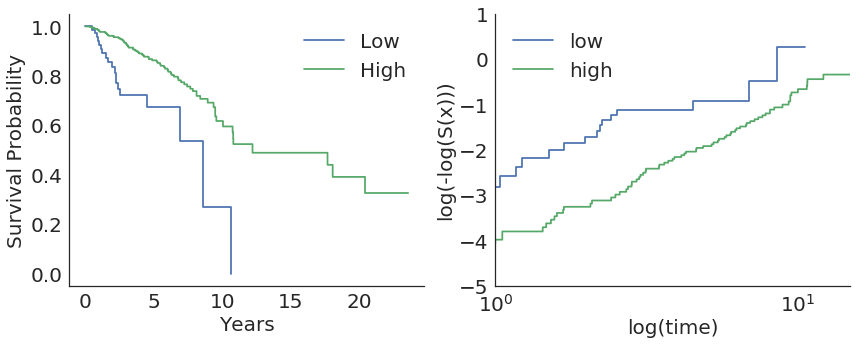

EIF3M
(72, 17055)
(646, 17055)


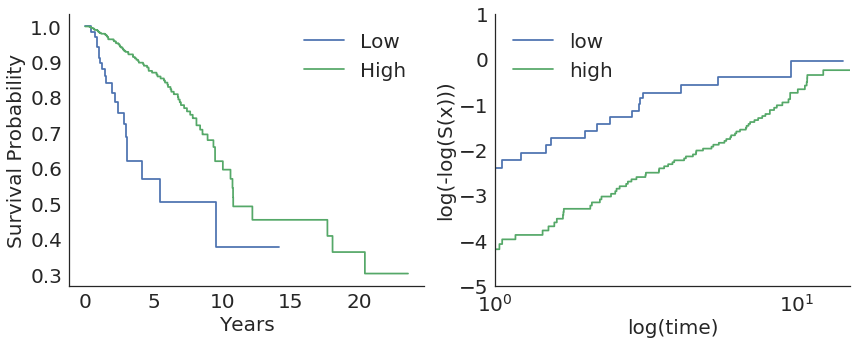

LIMCH1
(646, 17055)
(72, 17055)


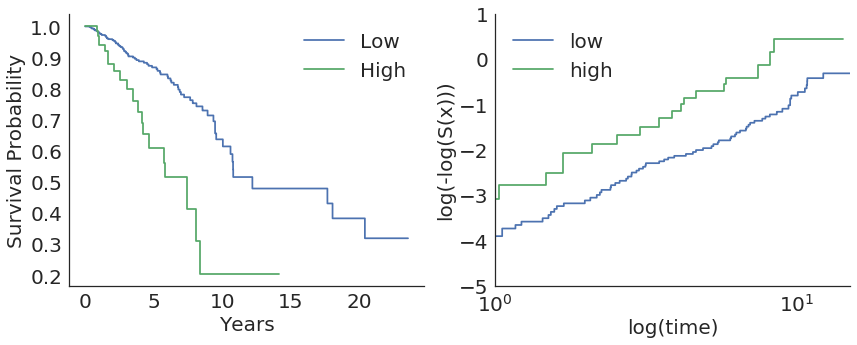

ARL14EP
(216, 17055)
(502, 17055)


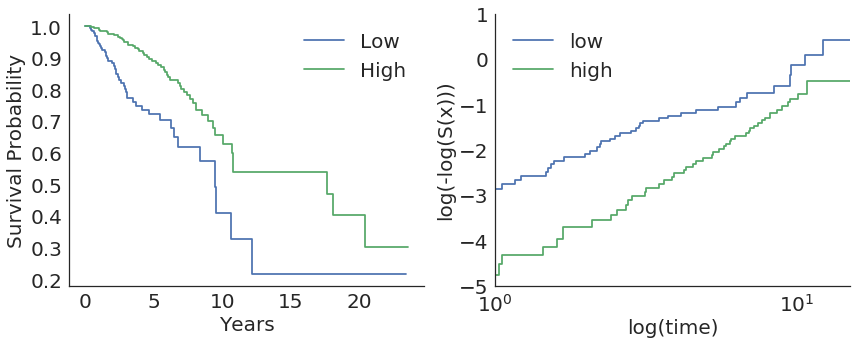

RGS3
(502, 17055)
(216, 17055)


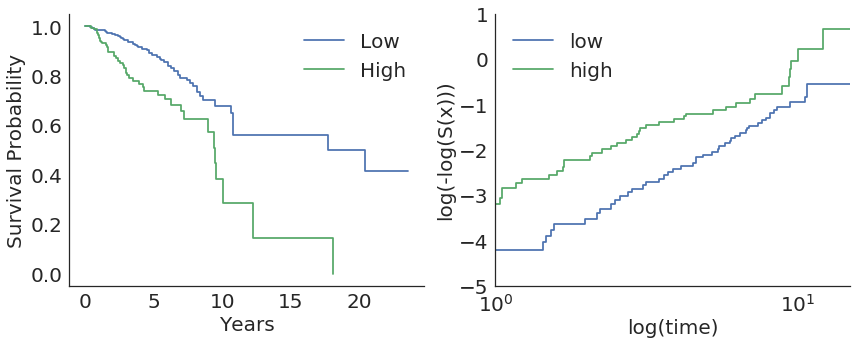

MYO3A
(72, 17055)
(646, 17055)


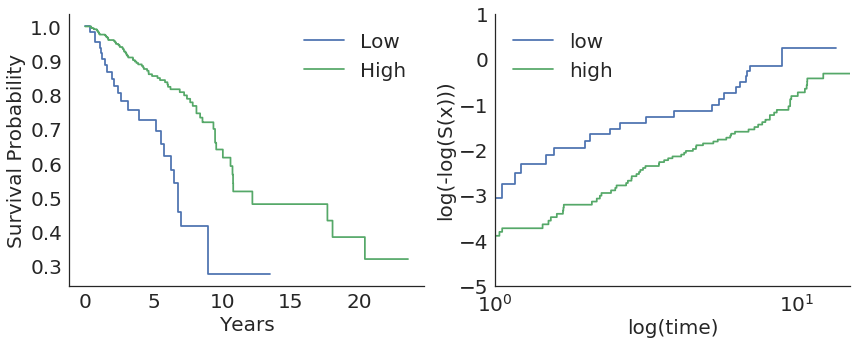

ATCAY
(646, 17055)
(72, 17055)


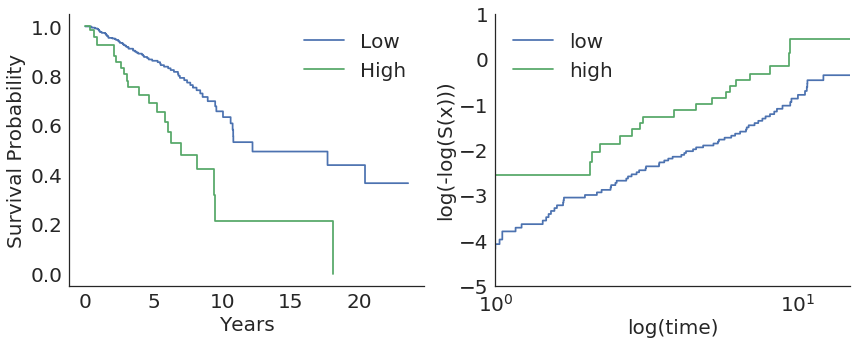

MAP2K6
(72, 17055)
(646, 17055)


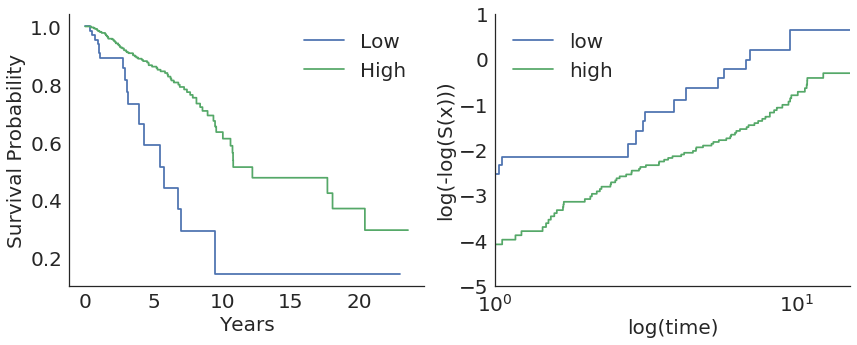

TTC39C
(72, 17055)
(646, 17055)


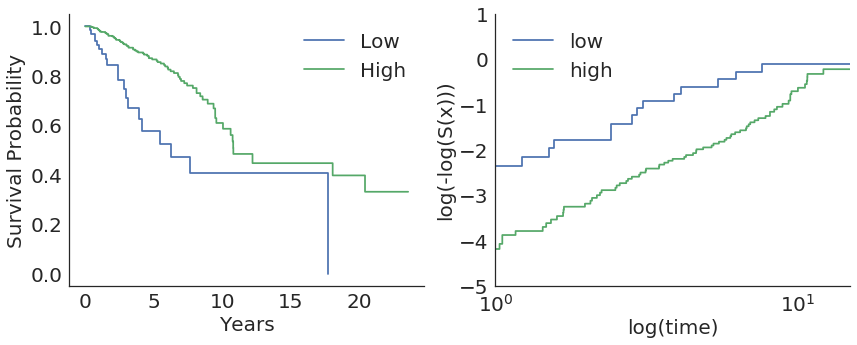

RBBP8
(72, 17055)
(646, 17055)


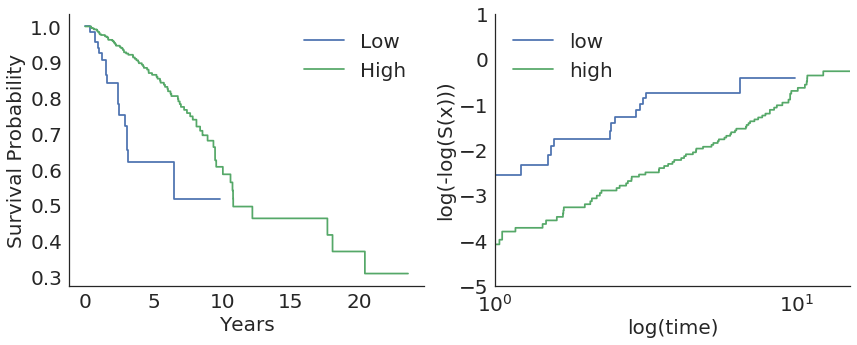

ZNF586
(216, 17055)
(502, 17055)


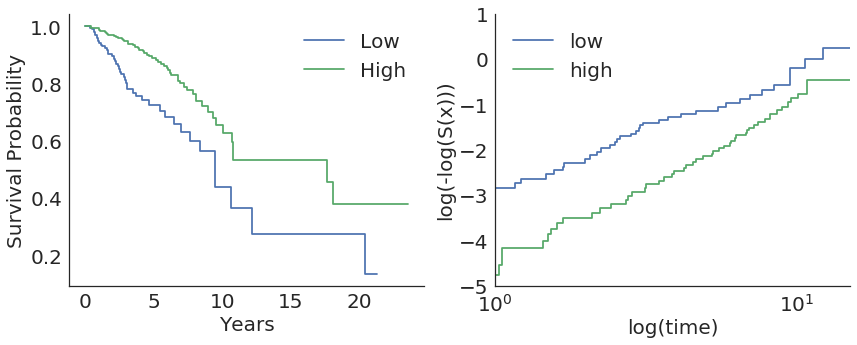

KRTCAP3
(144, 17055)
(574, 17055)


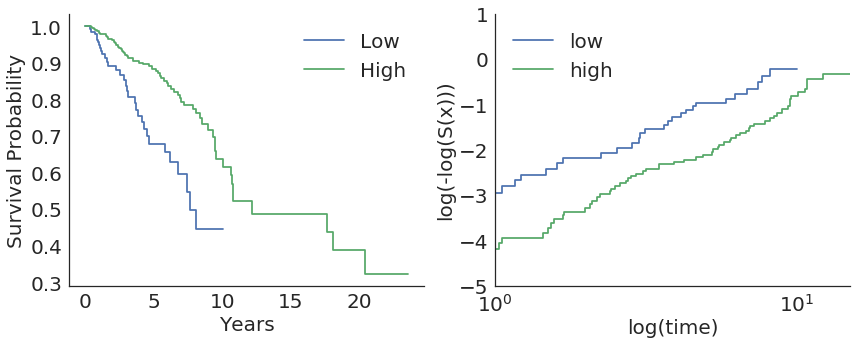

LRRC8D
(144, 17055)
(574, 17055)


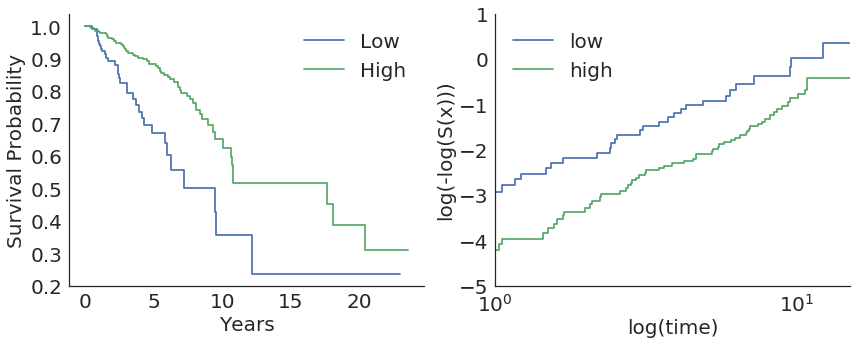

ZCCHC17
(144, 17055)
(574, 17055)


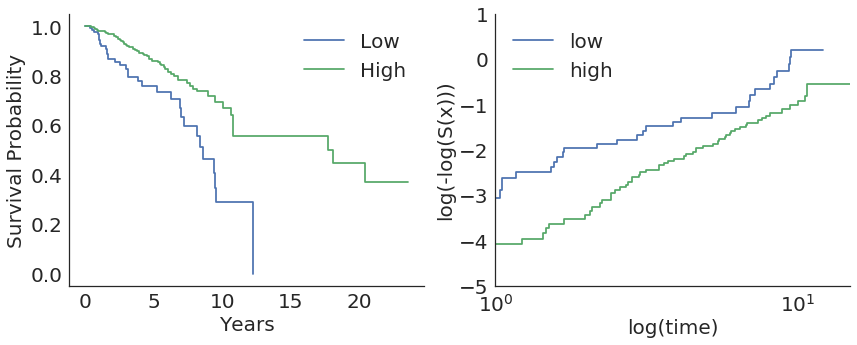

MARC1
(646, 17055)
(72, 17055)


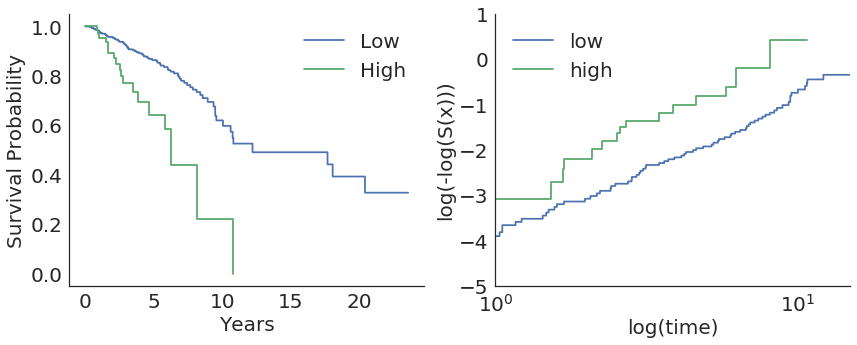

NEFH
(287, 17055)
(431, 17055)


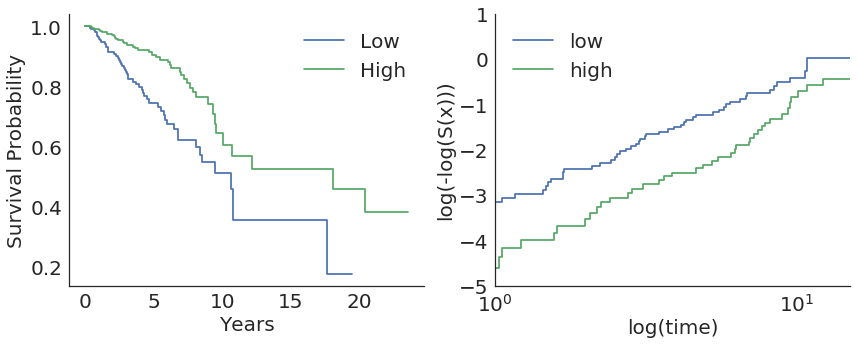

PHF20
(646, 17055)
(72, 17055)


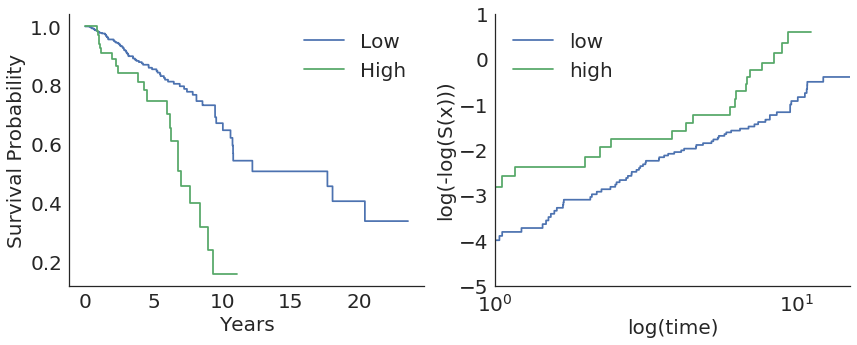

ODF3L2
(431, 17055)
(287, 17055)


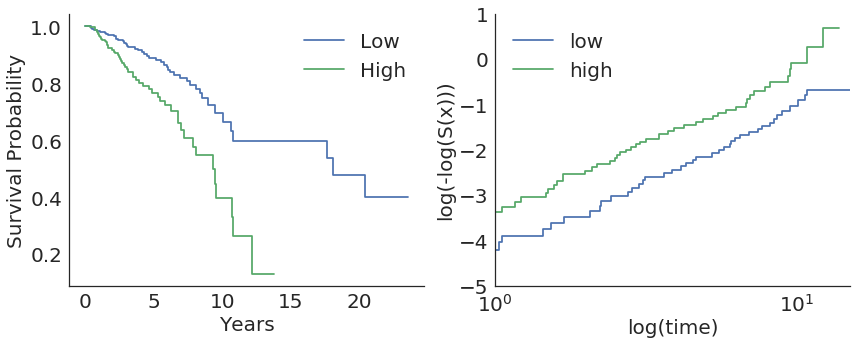

ADAMTSL1
(646, 17055)
(72, 17055)


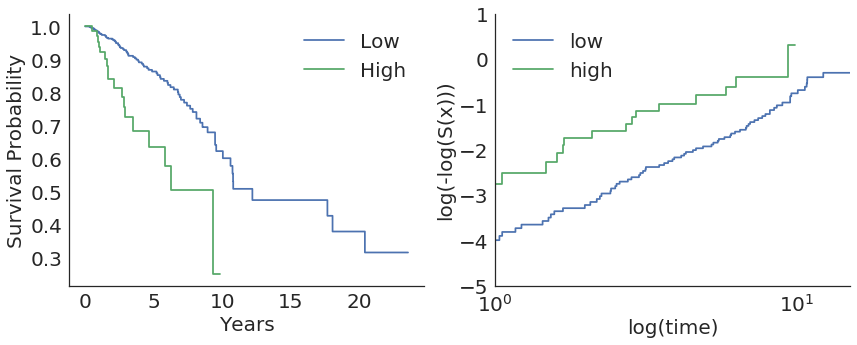

B4GALT2
(72, 17055)
(646, 17055)


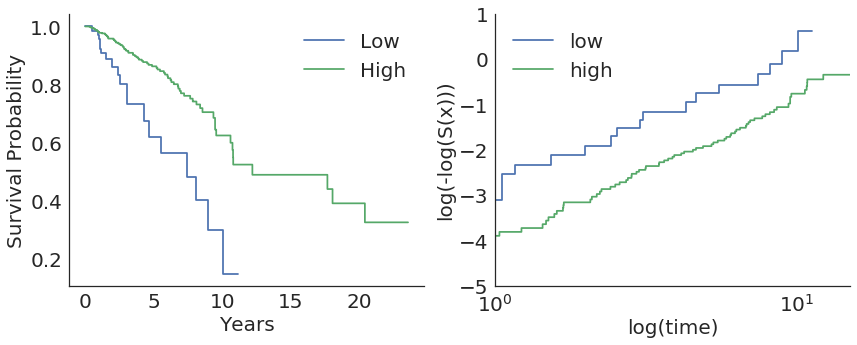

MYD88
(144, 17055)
(574, 17055)


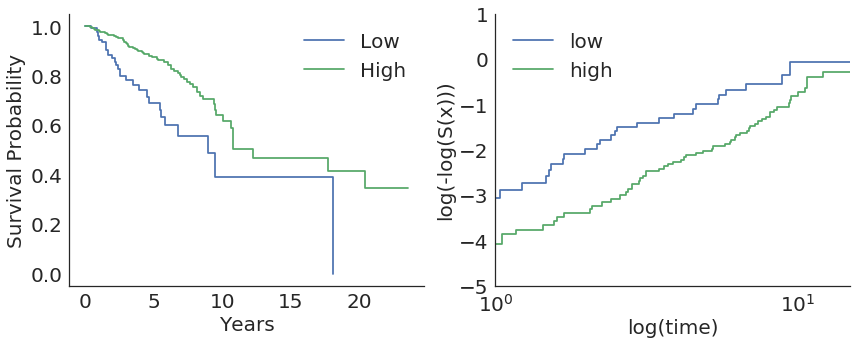

MTRNR2L3
(431, 17055)
(287, 17055)


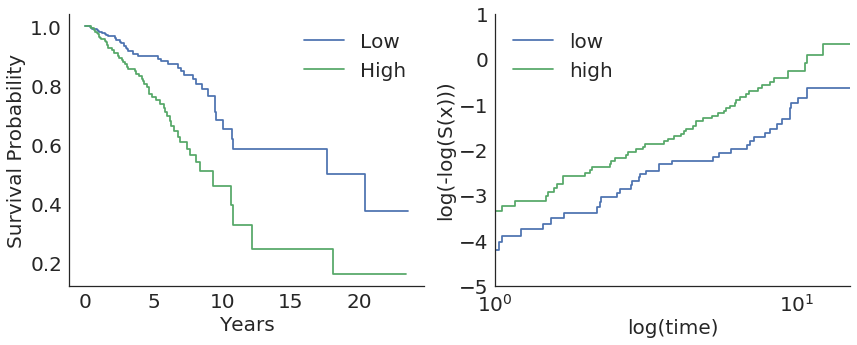

RBBP4
(144, 17055)
(574, 17055)


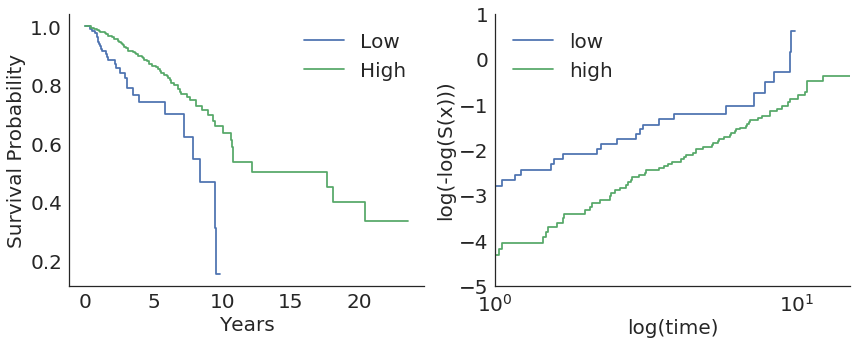

CYP24A1
(216, 17055)
(502, 17055)


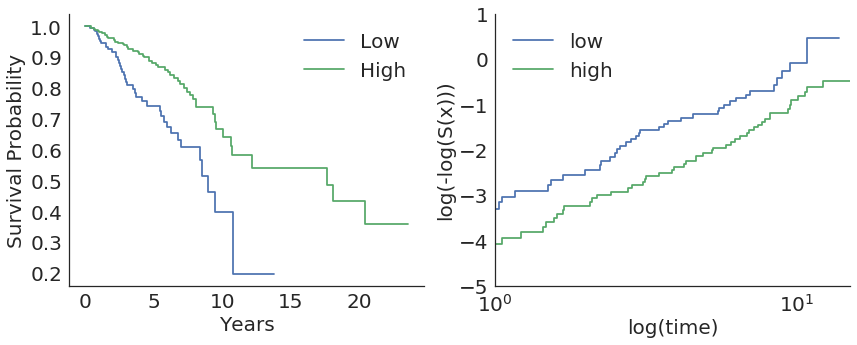

TCF4
(646, 17055)
(72, 17055)


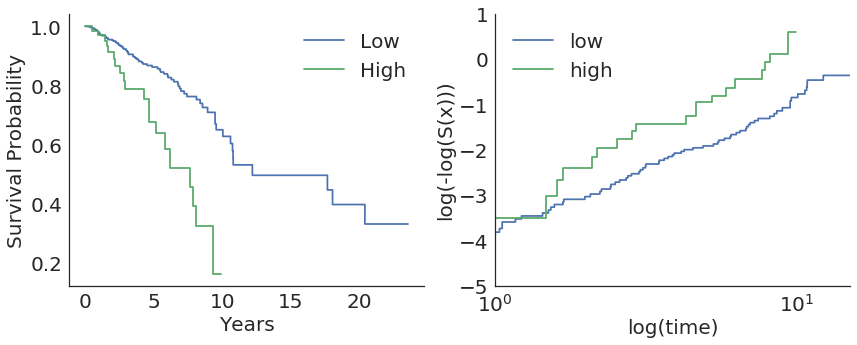

ZNF385B
(144, 17055)
(574, 17055)


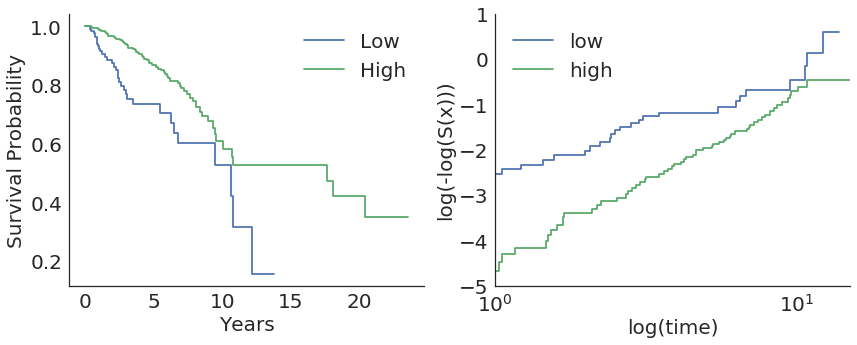

ZNF230
(72, 17055)
(646, 17055)


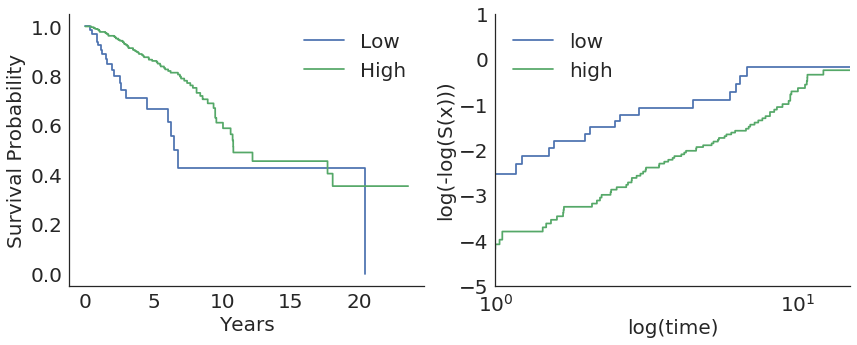

ENO2
(72, 17055)
(646, 17055)


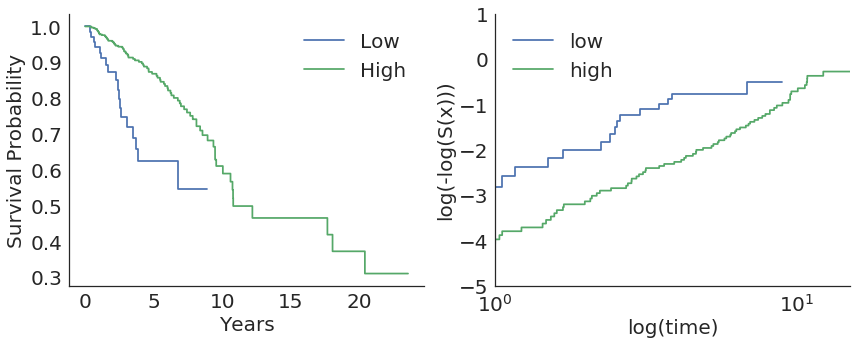

SBSPON
(72, 17055)
(646, 17055)


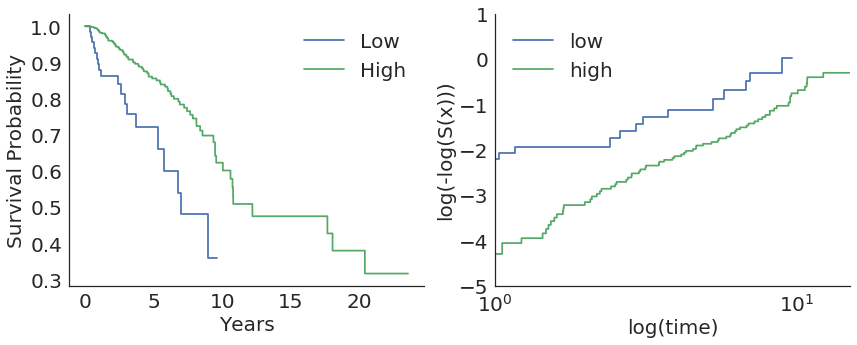

CBLN4
(646, 17055)
(72, 17055)


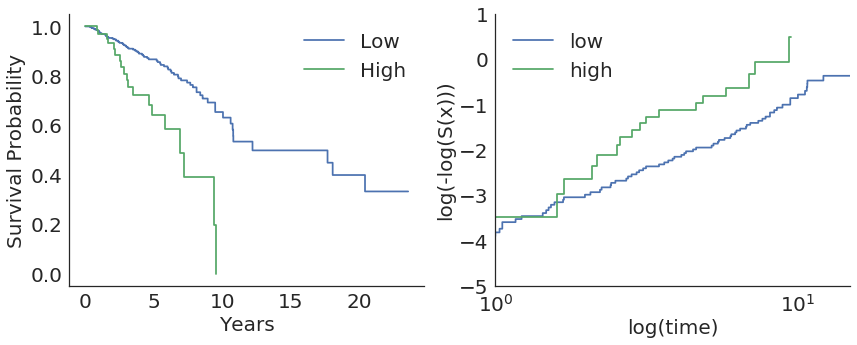

MORN3
(144, 17055)
(574, 17055)


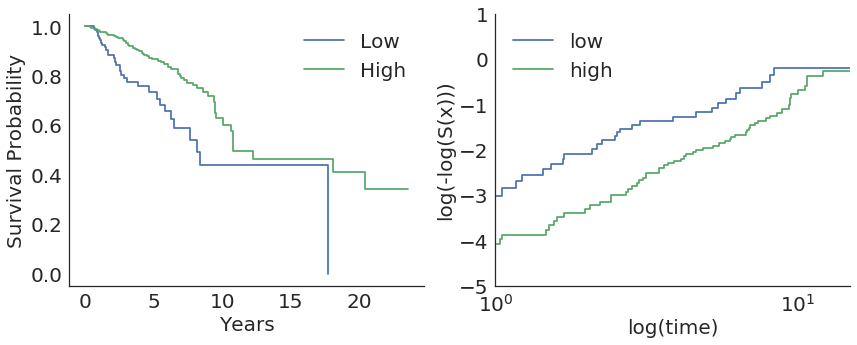

RXRG
(646, 17055)
(72, 17055)


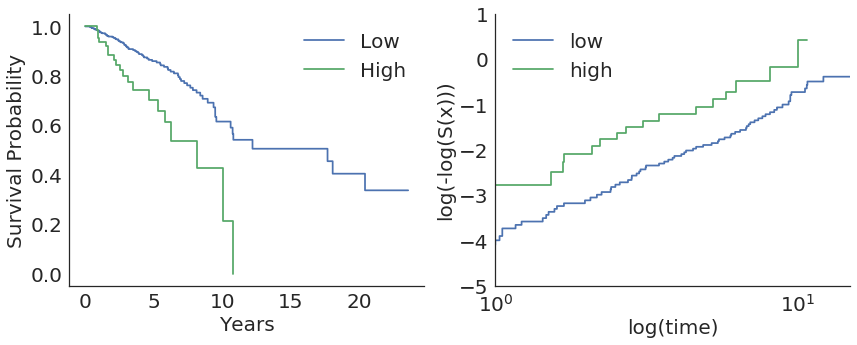

RPF1
(287, 17055)
(431, 17055)


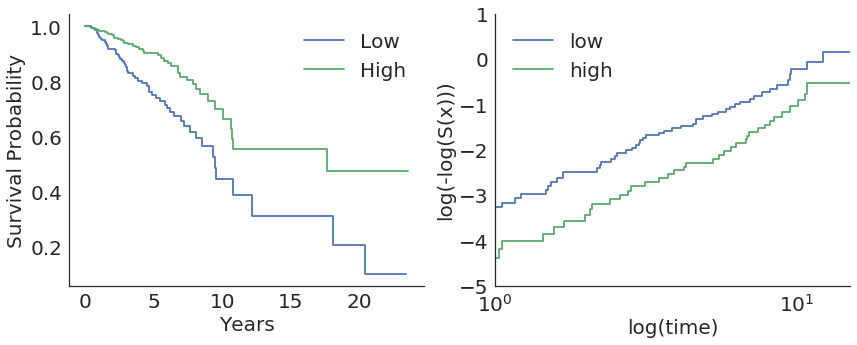

KLHL26
(72, 17055)
(646, 17055)


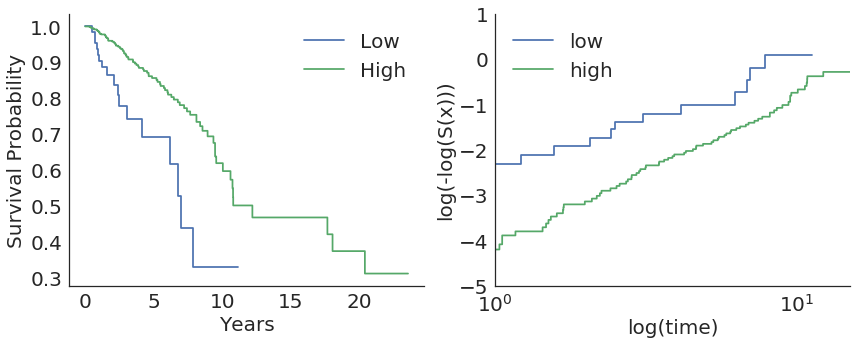

SS18
(72, 17055)
(646, 17055)


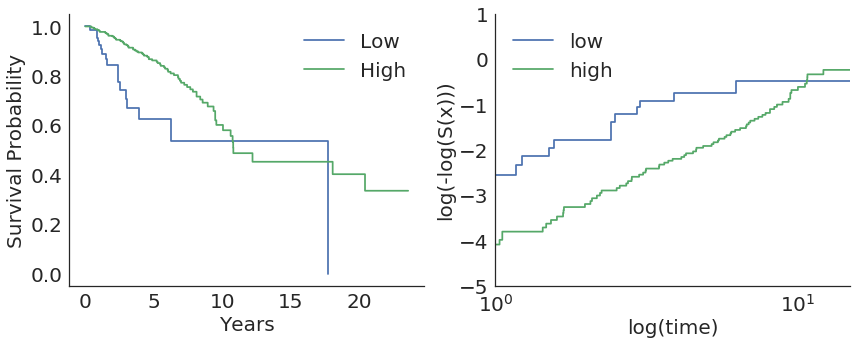

IQSEC1
(502, 17055)
(216, 17055)


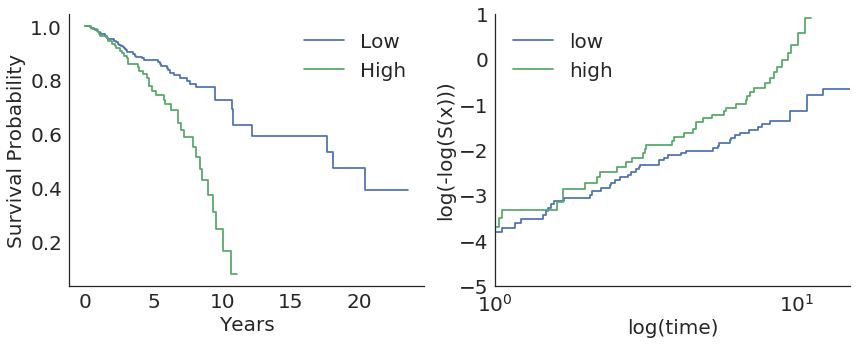

NCLN
(646, 17055)
(72, 17055)


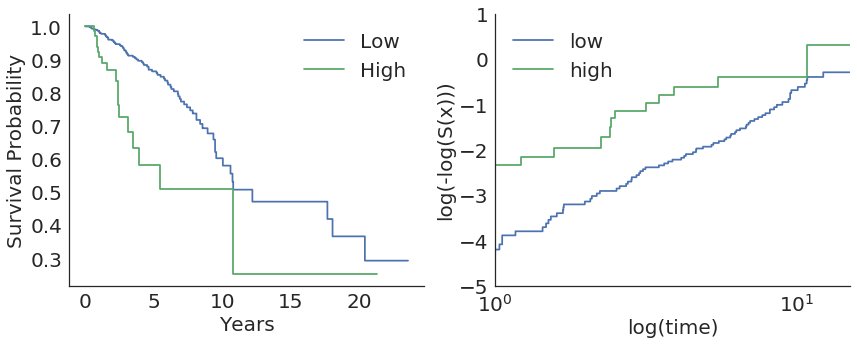

EPB41L4B
(646, 17055)
(72, 17055)


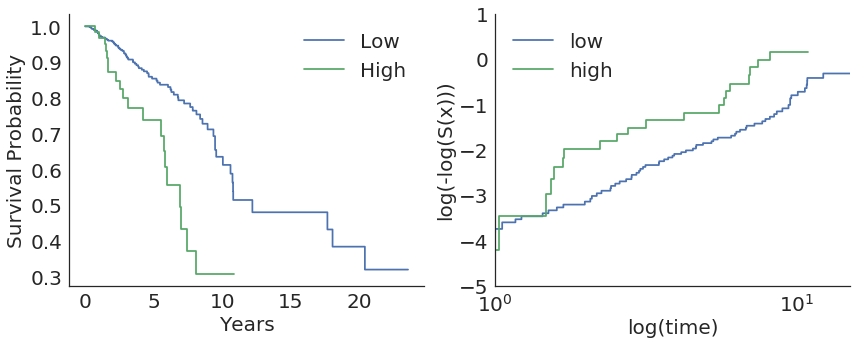

PI3
(216, 17055)
(502, 17055)


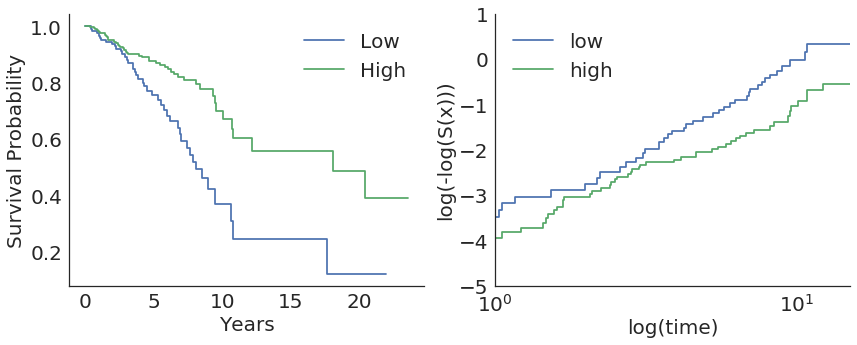

GJA4
(502, 17055)
(216, 17055)


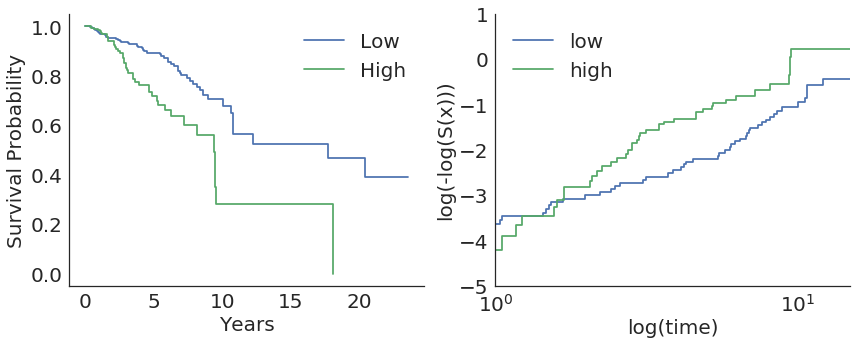

DLL4
(574, 17055)
(144, 17055)


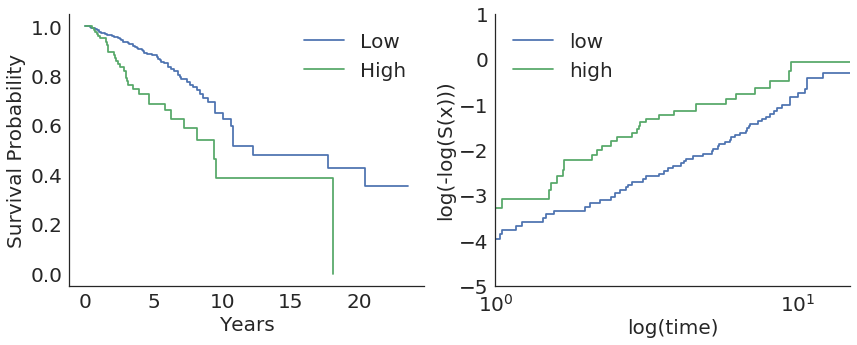

TDRD5
(72, 17055)
(646, 17055)


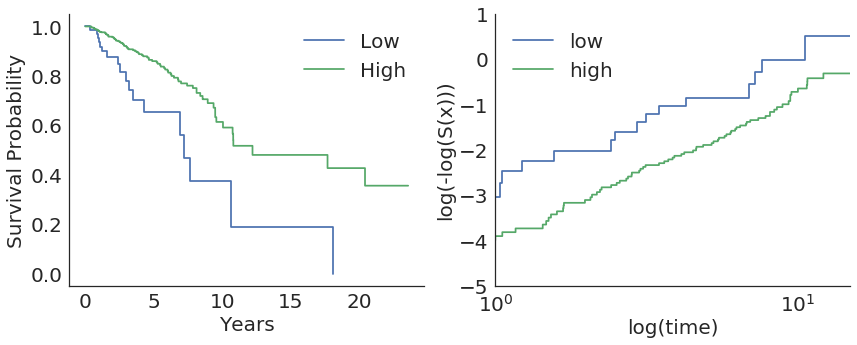

KCNJ8
(574, 17055)
(144, 17055)


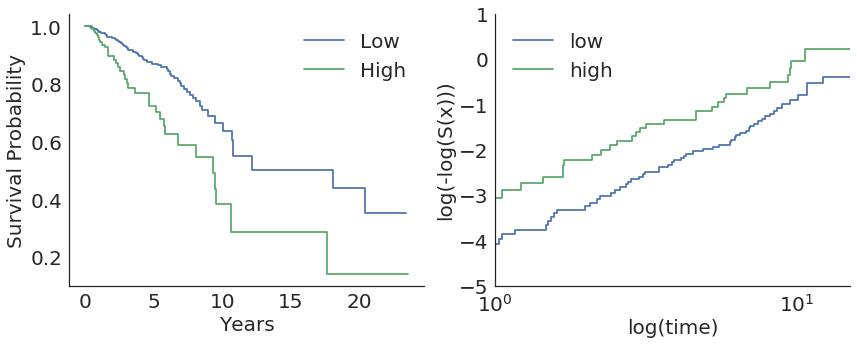

ADAM15
(646, 17055)
(72, 17055)


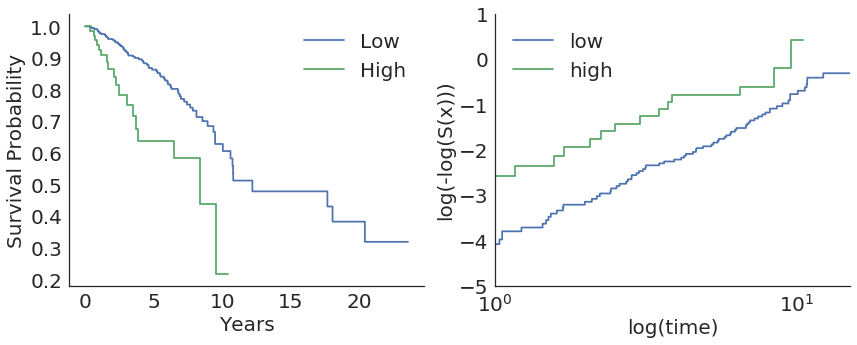

STOX1
(216, 17055)
(502, 17055)


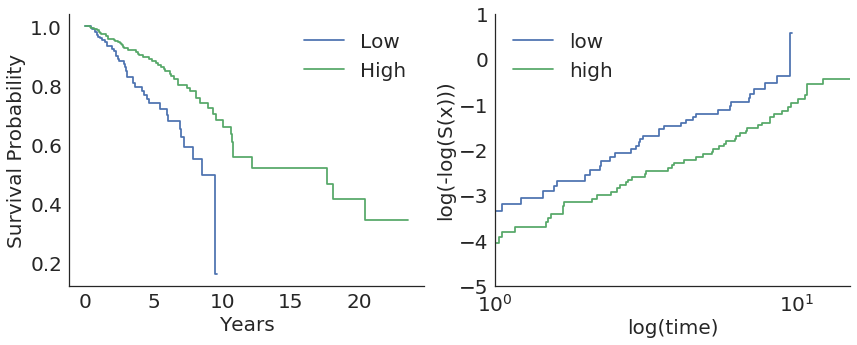

STXBP1
(646, 17055)
(72, 17055)


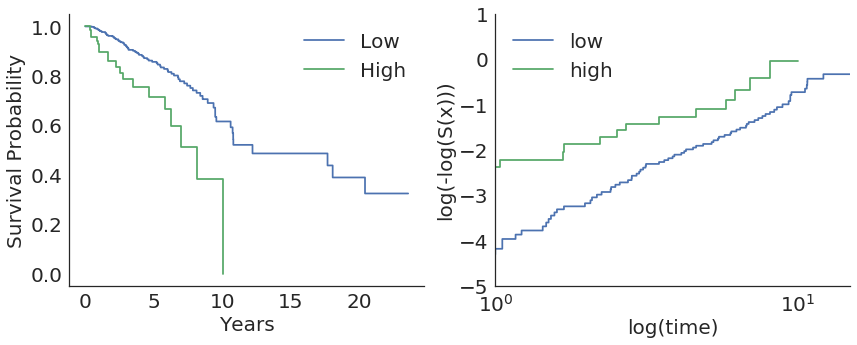

PBDC1
(646, 17055)
(72, 17055)


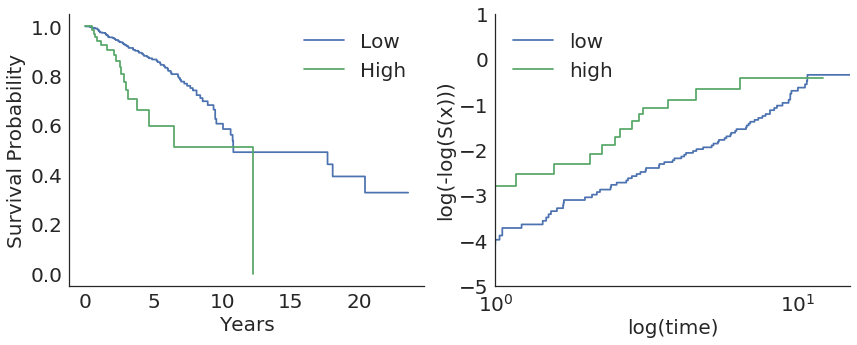

NPM1
(144, 17055)
(574, 17055)


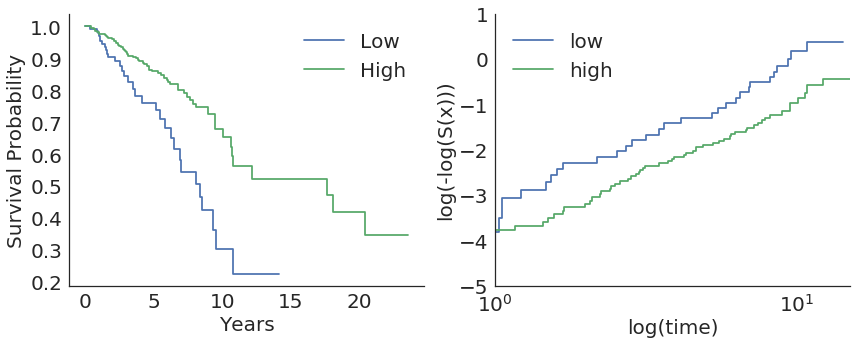

In [21]:
for gene,level in zip(gene_list,cutoff_level):
    if True:
        print(gene)
        #median_level = patient_df[gene].median()
        patient_df_binary[gene] = (patient_df[gene]>level).astype(int)

        lowgroup = patient_df_binary[patient_df_binary[gene]==0]
        highgroup = patient_df_binary[patient_df_binary[gene]==1]
        print(lowgroup.shape)
        print(highgroup.shape)
        
        
        fig, axes = plt.subplots(1, 2, sharex=False,sharey=False,figsize=(14,5))


        fig.patch.set_facecolor('white')
        kmf_low = KaplanMeierFitter()
        kmf_low.fit(lowgroup['Days']/365, 
                               lowgroup['Vitality'], label='low')
        
        kmf_high = KaplanMeierFitter()
        kmf_high.fit(highgroup['Days']/365, 
                               highgroup['Vitality'], label='high')
    
        kmf_low.plot(ci_show=False,ax=axes[0])
        kmf_high.plot(ci_show=False,ax=axes[0])

        font_prop = FontProperties()
        font_prop.set_size(20)
        axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
        axes[0].legend(['Low', 'High'],prop=font_prop)
        axes[0].spines['top'].set_color('none')
        axes[0].spines['right'].set_color('none')
        axes[0].set_xlabel('Years', **axis_font)
        axes[0].set_ylabel('Survival Probability', **axis_font)
        axes[0].grid(False)
        for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
            label.set_fontproperties(font_prop)
            label.set_fontsize(20) #Size here overrides font_prop


        kmf_low.plot_loglogs(ax=axes[1])
        kmf_high.plot_loglogs(ax=axes[1])

        axes[1].legend(['Low', 'High'])
        axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
        plt.legend(prop=font_prop,frameon=False)
        axes[1].spines['top'].set_color('none')
        axes[1].spines['right'].set_color('none')
        axes[1].set_xlabel('log(time)', **axis_font)
        axes[1].set_ylabel('log(-log(S(x)))', **axis_font)
        plt.xlim((1,15))
        plt.ylim((-5,1))

        for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
            label.set_fontproperties(font_prop)
            label.set_fontsize(20) #Size here overrides font_prop
        plt.show()
        




### Prepare the data by discretizing the genes along the best cutoff points

In [22]:
gene_assumptions_met = list(set(gene_list).difference(set(['GJA4','PI3','IQSEC1','HCFC2','SS18','CBLN4','CTXN1','TTC39C','RBBP8','TCF4','ZNF385B'])))

gene_list = breast_genes[breast_genes['Symbols'].isin(gene_assumptions_met)]['Symbols'].tolist()
cutoff_level = breast_genes[breast_genes['Symbols'].isin(gene_assumptions_met)]['Expression Cutoffs'].tolist()
print(gene_list[:20],cutoff_level[:20])

patient_df_binary = patient_df.loc[:,gene_list+['Days','Vitality']].copy()
valid_df_binary = valid_df.loc[:,gene_list+['Days','Vitality']].copy()

for gene,level in zip(gene_list,cutoff_level):
    patient_df_binary[gene] = (patient_df[gene]>level).astype(int)
    valid_df_binary[gene] = (valid_df[gene]>level).astype(int)

['SYT14', 'SSX2IP', 'PAK1', 'EIF3M', 'LIMCH1', 'ARL14EP', 'RGS3', 'MYO3A', 'ATCAY', 'MAP2K6', 'ZNF586', 'KRTCAP3', 'LRRC8D', 'ZCCHC17', 'MARC1', 'NEFH', 'PHF20', 'ODF3L2', 'ADAMTSL1', 'B4GALT2'] [0.0, 2.403109425162, 6.135199881266002, 12.005094159889998, 15.628450837010007, 4.8887615592600016, 4.484355633068, 0.0028708985586149995, 0.015136529803269997, 0.3670334740952, 2.8703589827429994, 7.83068651751, 5.556679573206002, 15.487808275599999, 4.229725595831002, 0.5119015875016, 14.426622641270008, 0.051651069511060035, 1.0809734583920003, 9.655696442439]


### Genes only (construct a model using only information from genes (excluding clinical information)

#### Determine the best number of features

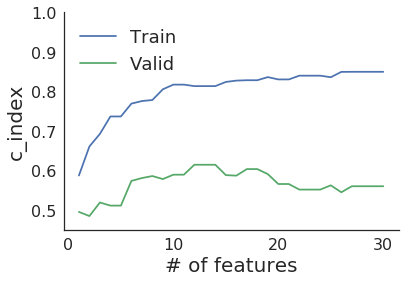

In [23]:
features_cindex = features_vs_cindex(patient_df_binary,valid_df_binary,gene_list[:30])
plt.plot(features_cindex[:,0],features_cindex[:,2])
plt.plot(features_cindex[:,0],features_cindex[:,1])
ax = plt.gca()
ax.legend(['Train', 'Valid'],fontsize=18,loc='upper left')
axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel("# of features",**axis_font)
plt.ylabel("c_index",**axis_font)
plt.ylim((0.45,1))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=16)

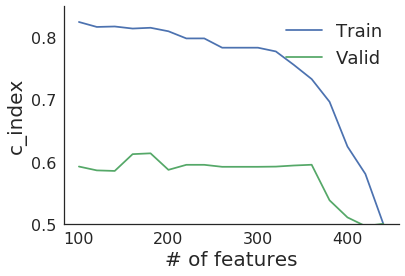

In [24]:
regular_cindex = regularization_vs_cindex(patient_df_binary,valid_df_binary,[i for i in range(100,450,20)],14,gene_list)

plt.plot(regular_cindex[:,0],regular_cindex[:,2])
plt.plot(regular_cindex[:,0],regular_cindex[:,1])
ax = plt.gca()
ax.legend(['Train', 'Valid'],fontsize=18,loc='upper right')
axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel("# of features",**axis_font)
plt.ylabel("c_index",**axis_font)
plt.ylim((0.5,0.85))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=16)

(718, 14)
n=718, number of events=100

           coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95    
SSX2IP  -0.3123     0.7317    0.1553 -2.0106 0.0444     -0.6169     -0.0078   *
PAK1    -0.4778     0.6201    0.2024 -2.3606 0.0182     -0.8746     -0.0810   *
EIF3M   -0.4391     0.6446    0.1984 -2.2132 0.0269     -0.8280     -0.0501   *
LIMCH1   0.4617     1.5868    0.1992  2.3179 0.0205      0.0712      0.8522   *
ARL14EP -0.2718     0.7620    0.1358 -2.0019 0.0453     -0.5380     -0.0056   *
RGS3     0.3135     1.3682    0.1349  2.3235 0.0202      0.0490      0.5780   *
MYO3A   -0.5039     0.6042    0.1924 -2.6187 0.0088     -0.8812     -0.1267  **
ATCAY    0.4806     1.6170    0.1909  2.5168 0.0118      0.1062      0.8549   *
MAP2K6  -0.4416     0.6430    0.2029 -2.1767 0.0295     -0.8393     -0.0439   *
ZNF586  -0.2715     0.7622    0.1353 -2.0058 0.0449     -0.5368     -0.0062   *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance 

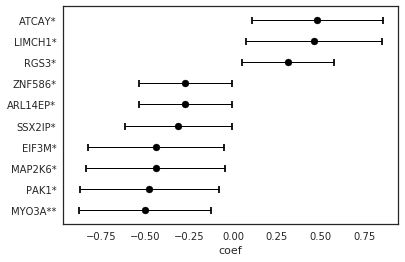

In [25]:
COX_dataset = patient_df_binary[gene_list[:12]+['Days','Vitality']]

print(COX_dataset.shape)

cph = COXPH_backward_elimination(COX_dataset,penalizer=160)
final_factors = cph.summary.index.tolist()

cph.print_summary()
c_index = concordance_index(COX_dataset['Days'],
                            -cph.predict_partial_hazard(COX_dataset[final_factors]).values.ravel(),
                                        COX_dataset['Vitality'])
print('Concordance index from the training set:',c_index)
cph.plot()

### Validation
COX_dataset = valid_df_binary

c_index = concordance_index(COX_dataset['Days'],
                            -cph.predict_partial_hazard(COX_dataset[final_factors]).values.ravel(),
                                        COX_dataset['Vitality'])

print('Concordance index from the validation set:',c_index)

### A model with cancer  stage information only

n=718, number of events=100

       coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
si  -1.6769     0.1870    0.4025 -4.1664 0.0000     -2.4659     -0.8879  ***
sii -0.9395     0.3908    0.2099 -4.4767 0.0000     -1.3509     -0.5281  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.707
validation c index 0.618324839353


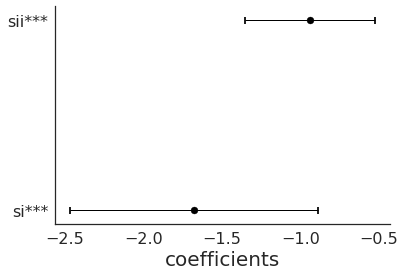

In [26]:
stage_dummies = pd.get_dummies(patient_df['Stage_number']).rename(columns={-1:'unk',1:'si',2:'sii',3:'siii',4:'siv'})
stage_dummies.drop(['unk'],axis=1,inplace=True)
#stage_dummies.drop(['siv'],axis=1,inplace=True)
COX_dataset = pd.concat([patient_df.loc[:,['Days','Vitality','HR_status']],stage_dummies,],axis=1)

cph = COXPH_backward_elimination(COX_dataset,penalizer=0)
cph.print_summary()
cph.plot()
final_factors = cph.summary.index.tolist()

ax = plt.gca()
axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel("coefficients",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=16)

# Model validation
stage_dummies = pd.get_dummies(valid_df['Stage_number']).rename(columns={-1:'unk',1:'si',2:'sii',3:'siii',4:'siv'})
stage_dummies.drop(['siv'],axis=1,inplace=True)

COX_dataset = pd.concat([valid_df.loc[:,['Days','Vitality','HR_status']],stage_dummies,],axis=1)

c_index = concordance_index(COX_dataset['Days'],
                            -cph.predict_partial_hazard(COX_dataset[final_factors]).values.ravel(),
                                        COX_dataset['Vitality'])

print('validation c index',c_index)

<a id='cell6'></a>


### Final COX model: cancer stage plus genes (include clinial information such as cancer stage, chemotherapy, hormone receptor status etc.)

[TOP](#cell100)

(718, 17055)
(718, 19)
n=718, number of events=100

           coef  exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
SYT14   -0.6646     0.5145    0.3180 -2.0897 0.0366     -1.2881     -0.0411    *
PAK1    -0.8520     0.4266    0.2910 -2.9278 0.0034     -1.4224     -0.2815   **
EIF3M   -0.6029     0.5472    0.2785 -2.1645 0.0304     -1.1490     -0.0568    *
LIMCH1   0.7301     2.0752    0.3236  2.2560 0.0241      0.0957      1.3645    *
ARL14EP -0.7847     0.4562    0.2255 -3.4798 0.0005     -1.2268     -0.3426  ***
RGS3     0.8299     2.2932    0.2180  3.8065 0.0001      0.4025      1.2573  ***
MYO3A   -0.6932     0.5000    0.2663 -2.6036 0.0092     -1.2152     -0.1713   **
ATCAY    0.8612     2.3660    0.2674  3.2202 0.0013      0.3369      1.3855   **
MAP2K6  -1.0804     0.3395    0.2881 -3.7499 0.0002     -1.6452     -0.5156  ***
KRTCAP3 -0.5540     0.5746    0.2554 -2.1690 0.0301     -1.0548     -0.0533    *
si      -1.8361     0.1594    0.4513 -4.0682 0.0000     -

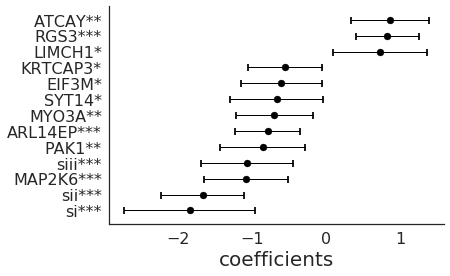

In [27]:
COX_dataset = patient_df.loc[:,['Stage_number']]
COX_dataset.fillna(-1,inplace=True)

stage_dummies = pd.get_dummies(COX_dataset['Stage_number']).rename(columns={-1:'unk',1:'si',2:'sii',3:'siii',4:'siv'})
stage_dummies.drop(['unk'],axis=1,inplace=True)
COX_dataset = pd.concat([patient_df_binary[gene_list[:12]+['Days','Vitality']],stage_dummies,patient_df[['HR_status']]],axis=1)

print(patient_df.shape)
print(COX_dataset.shape)

cph = COXPH_backward_elimination(COX_dataset,penalizer=0)
final_factors = cph.summary.index.tolist()
cph.print_summary()
cph.plot()

ax = plt.gca()
axis_font = {'fontname':'DejaVu Sans', 'size':'20'}
plt.xlabel("coefficients",**axis_font)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=16)


### Model validation:

In [28]:
COX_dataset = valid_df.loc[:,['Stage_number']]
COX_dataset.fillna(-1,inplace=True)

stage_dummies = pd.get_dummies(COX_dataset['Stage_number']).rename(columns={-1:'unk',1:'si',2:'sii',3:'siii',4:'siv'})
#stage_dummies.drop(['unk'],axis=1,inplace=True)
stage_dummies.drop(['siv'],axis=1,inplace=True)
COX_dataset = pd.concat([valid_df_binary[gene_list[:12]+['Days','Vitality']],stage_dummies,valid_df[['HR_status']]],axis=1)

c_index = concordance_index(COX_dataset['Days'],
                            -cph.predict_partial_hazard(COX_dataset[final_factors]).values.ravel(),
                                        COX_dataset['Vitality'])

print('Concordance index from validation data:',c_index)

Concordance index from validation data: 0.656880124086


### A final comparison of all three models

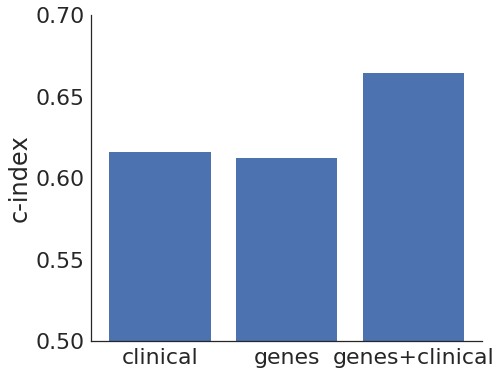

In [29]:
# Comparison of the models 
x_name = ['clinical','genes','genes+clinical']
concordances = [0.616,0.6121,0.6643]
fig = plt.figure(figsize=(7,6))
ax = fig.gca()
x = np.arange(len(x_name))  # <--
plt.bar(x, concordances)
plt.xticks(x, x_name)  # <--
plt.ylim((0.5,0.7))
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=22)
axis_font = {'fontname':'DejaVu Sans', 'size':'24'}
plt.ylabel('c-index', **axis_font)
plt.show()

<a id='cell8'></a>

### Conclusion
[Top](#cell100)

Although constructing a model using only gene expression was difficult. Combining genes and clinical information do seem to improve my survival predictions. There are multiple ways to improve the model. For example, non-linear relationships between the gene expression level and survival could be modelled using multi fractional polynomials. Another way to improve the model would be to combine genes into biologically meaningful categories and then construct new features.
I am also interested into examining other signals in the gene expression such as hormone receptor status. Although this do not have direct relevance to this product, it allows us to be more confident in signals in our data.